# Spam classification --- simple practice for using LSTMs
Data obtained from past [Kaggle](https://www.kaggle.com/uciml/sms-spam-collection-dataset) competition. Contains 5572 observations, each labeled as 'ham' or 'spam'. We will build a LSTM for classifying between the two, and explore exactly how complicated (or simple) a model is needed.

## Read data and validate its integrity

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [2]:
raw_data = pd.read_csv("spam.csv", encoding='latin-1')
raw_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Dropping the three unnamed columns, and confirm that there is no missing data

In [3]:
data = raw_data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
print(pd.DataFrame.sum(data.isna()))

v1    0
v2    0
dtype: int64


Rename the columns to something meaningful; visualize the class imbalance. Since there are many more spam than ham messages, we should use ROC/AUC as the evaluation metric, rather than straightforward accuracy!

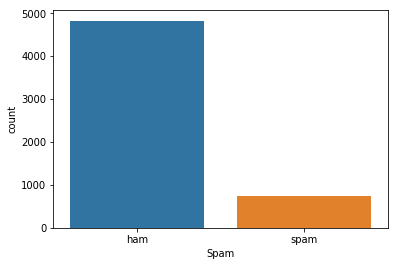

In [4]:
data = data.rename({"v1":"Spam", "v2": "Message"}, axis='columns')
sns.countplot(data.Spam)

## Process data for input into machine learning models
- Encode the classes as 1/0 (Spam/Ham). 
- Split the data into training and test sets. We will carry out cross-validation within the training set, and evaluate our model on the test set at the very end.

In [5]:
le = LabelEncoder()
Y = le.fit_transform(data.Spam)
#Y = Y.reshape(-1, 1)
X = data.Message

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, shuffle=True, random_state = 12321)

''' Verify that 'spam' -> 1. In binary classification problems, 
it's convention to encode the class we are interested in as 1. '''
print(le.inverse_transform([0,1]))

['ham' 'spam']


### *Tokenize* the messages --- i.e. text to numbers

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


Naturally not all messages have the same length. Padding is the most straightforward way to handle this difference --- we will null characters to the end of shorter sequences. Before doing so, we will first obtain some statistics on the distribution of message lengths...

We see that most messages are within 130 characters, but there are some excessively long ones (max 910). While I am limiting the sequence length to 200 characters, you are welcome to play with the value.

In [7]:
data.Message.apply(len).describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: Message, dtype: float64

Tokenize the messages --- represent each unique word into an integer. Fortunately, Keras has provided several convenience functions for doing just that. For this project, I am arbitrary limiting ourselves to use the *most common* 1000 words.

In [8]:
max_words = 1000 # Consider this number of most common words
max_len = 200    # Limit each sequence 

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
train_sequences = sequence.pad_sequences(train_sequences, maxlen=max_len)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences = sequence.pad_sequences(test_sequences, maxlen=max_len)

### Build Keras model

In [9]:
from keras.models import Model
from keras.layers import LSTM, Dense, Dropout, Input, Embedding, Input, Conv1D, MaxPool1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [10]:
def build_model(n_a = 64):
    ''' Building a Keras model, the functional approach. This is a many-to-1 model: the RNN
        iterates through many elements, before returning a single output.
    '''
    
    inputs = Input(name="inputs", shape=(max_len,))
    
    # Interestingly, without this Embedding layer, the model cannot learn anything useful.
    # The accuracy would remain at around 87% --- around the proportion of hams.
    # Tried embedding dimension of 50, but 10 actually already suffices for getting good performance
    # Lesson: try extracting USEFUL features from the text before sending into RNN
    layer = Embedding(max_words, 10, input_length=max_len)(inputs)
    layer = LSTM(n_a, dropout=0.5, recurrent_dropout=0.1)(layer)
    
    # Interesting how the model trains QUICKER with these intermediate layer! 
    layer = Dense(256, name="FC1", activation='relu')(layer)
    layer = Dropout(0.5)(layer)
    
    # Sigmoid activation: similar to binomial logistic regression
    layer = Dense(1, name="out_layer", activation="sigmoid")(layer)
    model = Model(inputs=inputs, outputs=layer)
    
    return model

Now let's investigate how complicated a model we need for this problem. Experiment shows that even with just 4 hidden units in the RNN, we are getting very good validation results. Wonder how it is like on the test set?

In [11]:
hidden_units = [4, 16, 64]
models = []
num_epochs = 8
loss_history = np.zeros(shape=(len(hidden_units), num_epochs))

callback_list = [EarlyStopping(monitor='val_loss', patience=5)]

In [12]:
for ia, na in enumerate(hidden_units):
    print("Training model with {} hidden units!".format(na))
    model = build_model(na)
    model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy'])
    history = model.fit(train_sequences, Y_train, validation_split=0.15, epochs=num_epochs, 
                        batch_size=128, verbose=1)
    models.append(model)
    loss_history[ia,:] = history.history['val_loss'] 

Training model with 4 hidden units!
Train on 4025 samples, validate on 711 samples
Epoch 1/8
4025/4025 [==============================] - 8s 2ms/step - loss: 0.6132 - acc: 0.8559 - val_loss: 0.4970 - val_acc: 0.8622
Epoch 2/8
4025/4025 [==============================] - 7s 2ms/step - loss: 0.3915 - acc: 0.8656 - val_loss: 0.3171 - val_acc: 0.8622
Epoch 3/8
4025/4025 [==============================] - 7s 2ms/step - loss: 0.2693 - acc: 0.8683 - val_loss: 0.1924 - val_acc: 0.8847
Epoch 4/8
4025/4025 [==============================] - 7s 2ms/step - loss: 0.1506 - acc: 0.9501 - val_loss: 0.0829 - val_acc: 0.9817
Epoch 5/8
4025/4025 [==============================] - 7s 2ms/step - loss: 0.0793 - acc: 0.9794 - val_loss: 0.0481 - val_acc: 0.9887
Epoch 6/8
4025/4025 [==============================] - 7s 2ms/step - loss: 0.0596 - acc: 0.9841 - val_loss: 0.0418 - val_acc: 0.9873
Epoch 7/8
4025/4025 [==============================] - 7s 2ms/step - loss: 0.0532 - acc: 0.9858 - val_loss: 0.0416 - va

As we can see, the 64 unit model converged more quickly, but as we trained for epochs the difference in val_loss is miniscule.

Text(0, 0.5, 'Crossentropy loss')

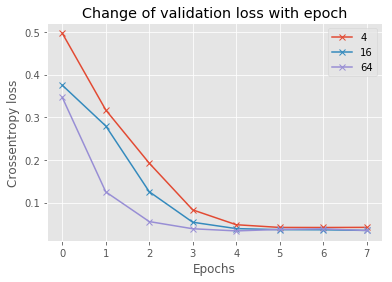

In [13]:
plt.style.use('ggplot')
for na, loss in zip(hidden_units, loss_history):
    plt.plot(range(len(loss)), loss, '-x', label="{}".format(na))
plt.legend()

plt.title("Change of validation loss with epoch")
plt.xlabel("Epochs")
plt.ylabel("Crossentropy loss")

## Evaluate on test data

Now let's evaluate on the test set. Two main observations
1. The test accuracy is higher than 87%, the proportion of hams in the overall data set. Therefore, our model has really learnt something. This is confirmed by looking at the ROC. See [this post](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c) for more information ROC/AUC.
2. A more complicated model doesn't necessarily lead to better performance --- but $\leq$0.5% of accuracy difference might not matter in industry applications.

The take-away lesson? Try to overfit, and then tune down model complexity. That way we get a model that works **and** is the leanest.

In [14]:
for model, na in zip(models, hidden_units):
    results = model.evaluate(test_sequences, Y_test)
    print("With {} hidden units, test loss={}, accuracy={}".format(na, results[0], results[1]))

836/836 [==============================] - 1s 1ms/step
With 4 hidden units, test loss=0.035770750272591294, accuracy=0.9904306220095693
836/836 [==============================] - 1s 998us/step
With 16 hidden units, test loss=0.04007513983772274, accuracy=0.9868421052631579
836/836 [==============================] - 1s 981us/step
With 64 hidden units, test loss=0.045501401096205873, accuracy=0.9868421052631579


In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

For 4 hidden RNN dimensions, the AUC is 0.9976851851851852
For 16 hidden RNN dimensions, the AUC is 0.9966168091168092
For 64 hidden RNN dimensions, the AUC is 0.9969729344729344


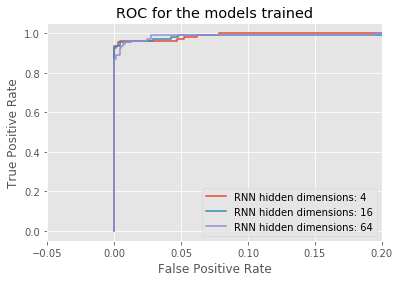

In [16]:
for model, na in zip(models, hidden_units):
    # Generate model predictions for test set
    # preds contains the probabilities that each observation belongs to class 1
    preds = model.predict(test_sequences)
    
    # Compute the ROC
    fpr, tpr, thresholds = roc_curve(Y_test, preds, pos_label=1)
    plt.plot(fpr, tpr, '-', label='RNN hidden dimensions: {}'.format(na))
    
    # Compute AUC
    auc_score = roc_auc_score(y_true=Y_test, y_score=preds)
    print("For {} hidden RNN dimensions, the AUC is {}".format(na, auc_score))

plt.xlim([-0.05, 0.2])
plt.title("ROC for the models trained")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()